In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [49]:
# build the dataset
block_size = 3 # context length of how many characters we take to predict the next one
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [14]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [ 0,  0,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1],
         [ 0,  0,  0],
         [ 0,  0, 19],
         [ 0, 19, 15],
         [19, 15, 16],
         [15, 16,  8],
         [16,  8,  9],
         [ 8,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [110]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
# embedding possible values into a 2dimensional space
C = torch.randn((27, 2))

In [10]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [23]:
# num inputs = num embeddings * dimension of embedding, so 3 * 2 = 6, num neurons is variable, in this case 100
num_neurons = 100
w1 = torch.randn((6, num_neurons)) 
b1 = torch.randn(num_neurons)

In [12]:
emb[:, 0, :].shape # gets the 32x2 of just the first character in the context

torch.Size([32, 2])

In [16]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # concatenates the 32x2 of each character in the context

torch.Size([32, 6])

In [18]:
emb.view(32, 6)

tensor([[-0.3925, -0.0328, -0.3925, -0.0328, -0.3925, -0.0328],
        [-0.3925, -0.0328, -0.3925, -0.0328,  0.5620,  1.8049],
        [-0.3925, -0.0328,  0.5620,  1.8049,  2.0279, -0.0255],
        [ 0.5620,  1.8049,  2.0279, -0.0255,  2.0279, -0.0255],
        [ 2.0279, -0.0255,  2.0279, -0.0255,  1.1034,  0.0220],
        [-0.3925, -0.0328, -0.3925, -0.0328, -0.3925, -0.0328],
        [-0.3925, -0.0328, -0.3925, -0.0328, -0.0593, -2.0287],
        [-0.3925, -0.0328, -0.0593, -2.0287,  1.2847,  0.3126],
        [-0.0593, -2.0287,  1.2847,  0.3126,  1.3365,  0.1396],
        [ 1.2847,  0.3126,  1.3365,  0.1396,  1.8225, -0.9827],
        [ 1.3365,  0.1396,  1.8225, -0.9827,  1.3365,  0.1396],
        [ 1.8225, -0.9827,  1.3365,  0.1396,  1.1034,  0.0220],
        [-0.3925, -0.0328, -0.3925, -0.0328, -0.3925, -0.0328],
        [-0.3925, -0.0328, -0.3925, -0.0328,  1.1034,  0.0220],
        [-0.3925, -0.0328,  1.1034,  0.0220,  1.8225, -0.9827],
        [ 1.1034,  0.0220,  1.8225, -0.9

In [20]:
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
h

tensor([[-0.8676, -0.8351, -0.9308,  ..., -0.9356,  0.9077,  0.3320],
        [-0.7464, -0.7550, -0.0281,  ..., -0.9969,  0.9893,  0.6665],
        [ 0.7128, -0.9859, -0.9637,  ..., -0.9866,  0.3468, -0.9625],
        ...,
        [-0.9874, -0.9747, -0.7960,  ..., -0.8288,  0.9864,  0.0471],
        [ 0.9664, -0.5690, -0.7565,  ..., -0.8738,  0.0808, -0.6600],
        [ 0.9619, -0.6916, -0.6366,  ..., -0.9389,  0.4939, -0.9810]])

In [24]:
w2 = torch.randn((num_neurons, 27))
b2 = torch.randn(27)

In [25]:
logits = h @ w2 + b2

In [26]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [28]:
probs.shape

torch.Size([32, 27])

In [31]:
loss = -probs[torch.arange(32), Y].log().mean()

In [32]:
loss

tensor(16.2689)

In [33]:
# make this look beautiful

In [111]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [135]:
g = torch.Generator().manual_seed(2147483647)
num_dimensions = 10
num_characters = 27
num_neurons = 200
C = torch.randn((num_characters, num_dimensions), generator=g)
w1 = torch.randn((block_size * num_dimensions, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
w2 = torch.randn((num_neurons, num_characters), generator=g)
b2 = torch.randn(num_characters, generator=g)
parameters = [C, w1, b1, w2, b2]

In [136]:
sum(p.nelement() for p in parameters) # total num of parameters

11897

In [137]:
for p in parameters:
    p.requires_grad = True

In [151]:
epochs = 1
lre = torch.linspace(-3, 0, epochs)
lrs = 10 ** lre
lr = 0.1
minibatch_size = 128

In [141]:
lri = {}

In [156]:
for i in range(epochs):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (minibatch_size, ))
    
    # forward pass
    emb = C[Xtr[ix]] # (minibatch_size, 3, 2)
    h = torch.tanh(emb.view(-1, num_dimensions * block_size) @ w1 + b1) # (minibatch_size, 100)
    logits = h @ w2 + b2 # (minibatch_size, 27)
    print(logits, logits.shape)
    # same as cross entropy
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -probs[torch.arange(minibatch_size), Y].log().mean()
    print(Ytr[ix], Ytr[ix].dtype)
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += p.grad * -lr#-lrs[i]
    
    
    lri[lre[i]] = loss.item()
print(loss.item())

tensor([[-7.3456, -0.0780, -1.5172,  ..., -4.0374, -1.9827, -1.4508],
        [-3.7813,  5.4997, -2.8544,  ..., -1.4516,  3.8933, -0.5286],
        [ 4.4186,  2.6883,  1.6957,  ..., -0.1444,  3.0985,  0.2528],
        ...,
        [ 6.5694,  4.3394,  4.8994,  ...,  2.4829,  6.7284,  3.2338],
        [ 5.1647,  5.5094,  1.4368,  ..., -8.5835,  4.8332, -1.1759],
        [-5.1507,  5.2572, -1.4344,  ..., -3.3349,  3.8794, -0.8811]],
       grad_fn=<AddBackward0>) torch.Size([128, 27])
tensor([20,  5,  0,  9,  1, 14,  9, 16,  1, 19, 18,  1, 15,  1,  0,  5, 12,  0,
        16,  9,  1, 20, 11, 25,  7, 14,  0, 19, 11, 24, 19,  9, 26,  1,  4,  4,
         0, 14,  5, 21,  1,  0,  1, 12, 15, 12,  9,  8, 12,  1, 18,  1,  5, 12,
         5,  0,  9, 20,  6, 19,  1,  4, 13, 14,  1, 19, 14, 18,  5, 18,  5,  0,
        26,  0,  0,  9,  0,  5,  1,  0,  7, 20,  0, 19,  0, 14,  9,  9,  9,  9,
         0,  0,  0,  1,  1, 11, 19,  8,  0, 19,  3, 18,  0,  1,  9,  5,  1, 12,
         5, 14,  5,  7,  5,  9, 1

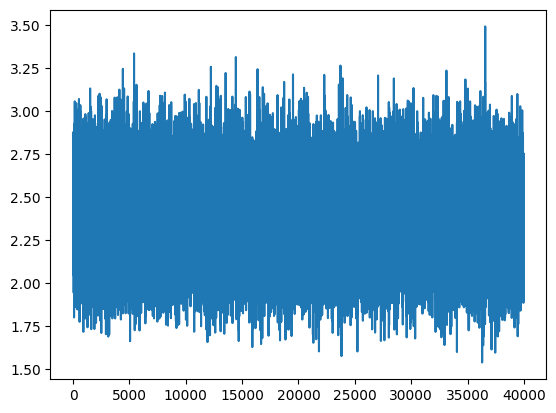

In [129]:
plt.plot(range(epochs), list(lri.values()))

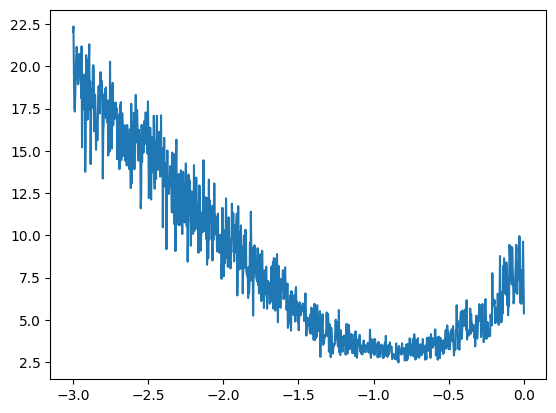

In [99]:
# plt.plot(lri.keys(), lri.values())

In [134]:
emb = C[Xva]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Yva)
loss.item()

2.2677841186523438

In [149]:
# training split, dev/validation split, test split
# 80% train, 10% dev, 10% test


In [157]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1)) @ w1 + b1
        logits = h @ w2 + b2
        print(logits.shape)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out[:-1]]))

torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
arie
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
aria
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
iya
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
arie
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
arie
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
arii
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
ari
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
aria
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
arie
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27